<a href="https://colab.research.google.com/github/jhill1/tidal_analysis_workshop/blob/main/Tidal_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

Tides are a fundemantal part of a number of coastal prcesses. As sea levels rise, tides will change, and hence our flood risk, coastal geomorphology and eolocigcal systems will also chnage as a consequence.

This Jupyter notebook will take you through the analysis of sea level data to extract tidal information.

# What to do

Run each block of code sequentially. In some places, template code is given for you to edit to carry out your own analysis.

There are questions posed along the way to help gain understanding.


In [1]:
# let's install some essential python modules
!pip install wget
!pip install uptide

  Preparing metadata (setup.py) ... done
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9655 sha256=e92156277272ec709c8e48e52997e312174238d42b0385df8cc3a8a2f577bc9b
  Stored in directory: /root/.cache/pip/wheels/8b/f1/7f/5c94f0a7a505ca1c81cd1d9208ae2064675d97582078e6c769
Successfully built wget


In [2]:
# import the modules we need
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import wget
import os
import numpy as np
import uptide
import pytz
import math


Now we have out environment set up. We can create a couple of "helper" functions to make life easier later!

In [3]:
def read_and_process_data(filename):
    tide_data = pd.read_csv(filename, header=None)
    tide_data['Date'] = pd.to_datetime(dict(year=tide_data[0], month=tide_data[1], day=tide_data[2], hour=tide_data[3]))
    # col 0 is year, col 1 is month, col2 is day, col3 hour
    tide_data = tide_data.drop([0,1,2,3], axis = 1)
    tide_data = tide_data.rename(columns={4: "Tide"})
    tide_data = tide_data.set_index('Date')
    tide_data = tide_data.mask(tide_data['Tide'] < -300)

    return tide_data

def extract_single_year_remove_mean(year, data):
    year_string_start = str(year)+"0101"
    year_string_end = str(year)+"1231"
    year_data = data.loc[year_string_start:year_string_end, ['Tide']]
    # remove mean to oscillate around zero
    mmm = np.mean(year_data['Tide'])
    year_data['Tide'] -= mmm

    return year_data

We are going to use data from the long term tidal record dataset held by the School of Ocean and Earth Science and Technology, University of Hawaii. Some of their tidal records go back over 100 years. We're going to download data for three locations in Australia: Freemantle, WA; Booby Island, QLD; and Fort Denison, NSW.

In [4]:
FortDenison_url = "https://uhslc.soest.hawaii.edu/data/csv/fast/hourly/h333.csv"
BoobyIsland_url = "https://uhslc.soest.hawaii.edu/data/csv/fast/hourly/h336.csv"
Freemantle_url = "https://uhslc.soest.hawaii.edu/data/csv/fast/hourly/h175.csv"
urls = [FortDenison_url, BoobyIsland_url, Freemantle_url]

# fetch our data and store
for url in urls:
    file_name = os.path.basename(url) # get the full path to the file
    if os.path.exists(file_name):
        os.remove(file_name) # if exists, remove it directly
    file_name = wget.download(url, out=".")

We now have three csv files which should be stored in your temporary files here (click the little folder symbol to the left and you should see the three .csv files).

In [5]:
# load and store as a pandas dataframe
Fort_Denison = read_and_process_data("h333.csv")
Booby_Island = read_and_process_data("h336.csv")
Freemantle = read_and_process_data("h175.csv")


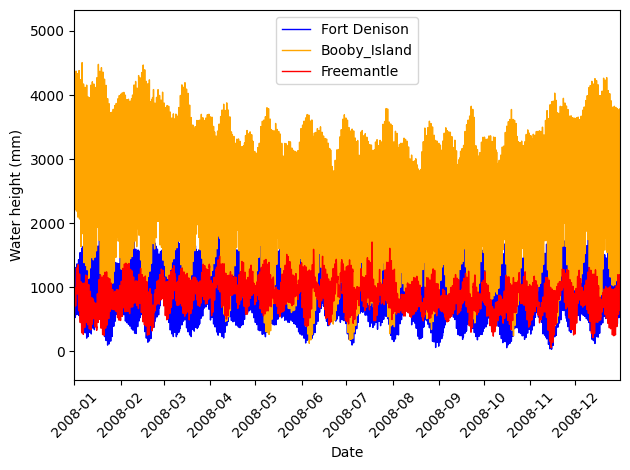

In [6]:
# Let's plot 1 years' worth of tidal data
fig_summary=plt.figure()
ax=fig_summary.add_subplot(111)
fd = ax.plot(Fort_Denison['Tide'], color="blue", lw=1, label="Fort Denison")
bi = ax.plot(Booby_Island['Tide'], color="orange", lw=1, label="Booby_Island")
f = ax.plot(Freemantle['Tide'], color="red", lw=1, label="Freemantle")
ax.set_xlabel("Date")
ax.set_ylabel("Water height (mm)")
ax.tick_params(axis='x', rotation=45)
ax.legend()
ax.set_xlim([datetime.date(2008, 1, 1), datetime.date(2008, 12, 31)])
fig_summary.tight_layout()

The plot, though busy, already shows some interesting features. Booby Island has the highest tidal range and shows a clear annual signal. Freemantle has the smallest tidal range and seems fairly constant. Let's now look at one month in detail:

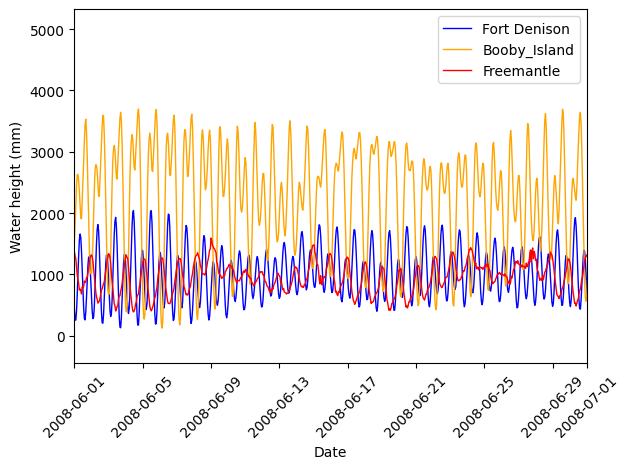

In [7]:
fig_june=plt.figure()
ax=fig_june.add_subplot(111)
fd = ax.plot(Fort_Denison['Tide'], color="blue", lw=1, label="Fort Denison")
bi = ax.plot(Booby_Island['Tide'], color="orange", lw=1, label="Booby_Island")
f = ax.plot(Freemantle['Tide'], color="red", lw=1, label="Freemantle")
ax.set_xlabel("Date")
ax.set_ylabel("Water height (mm)")
ax.tick_params(axis='x', rotation=45)
ax.legend()
ax.set_xlim([datetime.date(2008, 6, 1), datetime.date(2008, 7, 1)])
fig_june.tight_layout()

We can now see more of the tidal signals. You may notice Freemantle shows fewer wiggles than the other two locations; this is because it is a diurnal tide: one tide per day. Fort Denison has a clear two tides per day; semi-diurnal. Booby Island normally has two tides per days, but some days, those two tides effectively blend into one (see around the 17th June). This is a mixed diurnal-semi diurnal system.

All tidal signals are essentially a mix of multiple sine curves. We known what the frequency of the external forcing is for tides (the rotation of the earth, the movement of the moon around the earth, etc), which allows us to break up the signal into constituent parts: the tidal constituents. These are often given labels such as M2, S2, K1, O1, etc. Each one has a particular frequency as given in the table below.

Decription                        |	Darwin symbol | Period (h) | Speed (°/h)
----------------------------------|---------------|------------|------------
Principal lunar semidiurnal	      | M2            | 12.4206012 | 28.9841042
Principal solar semidiurnal	      | S2	          | 12         |	30	      
Lunar diurnal	                    | K1	          | 23.9344721 |	15.0410686
Lunar diurnal	                    | O1	          | 25.8193387 |	13.9430356
Lunisolar semidiurnal	            | K2	          |11.96723606 |	30.0821373
Larger lunar elliptic semidiurnal	| N2	          | 12.6583475 |	28.4397295

There are over 400 different contiuents, but 60-ish is considered enough for accurate tidal predictions, but fewer still can be used for useful tidal predictions. The tidal signal can then be reconstructed by summing sine curves of the correct frequency and amplitude (and phase) to recreate and then predict the tides. At each location the amplitude and phase will be different.

Let's add up some sine curves to make something like the tide signals above.


# Sine curves

Sine cuves can be generalised to the formula:

$y = A sin (Bx+C) + D$

$A$ is the amplitude, $2\pi/B$ is the period, $C$ is the phase shift and $D$ is the vertical shift. We know the period (from the table above!) and $D$ is not relevant here, so we have two parameters to play with: $A$ and $C$.

Text(0, 0.5, 'Water height (m)')

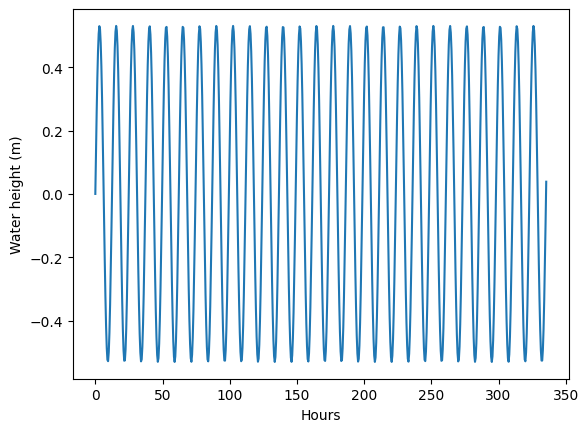

In [8]:
A_m2 = 0.53
B_m2 = 12.4206012 # hours
C_m2 = 0

times = np.arange(0,24*14,0.5) # 14 days in hours
sin_curve = A_m2*np.sin(2*math.pi/B_m2*times + C_m2)

plt.plot(times,sin_curve)
plt.xlabel("Hours")
plt.ylabel("Water height (m)")

Text(0, 0.5, 'Water height (m)')

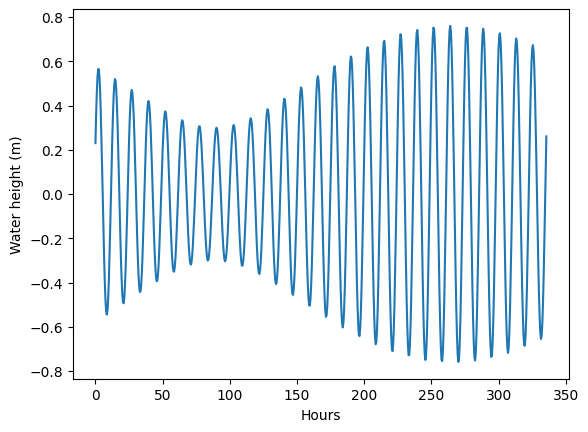

In [9]:
# Let's now add an S2 curve on that
A_s2 = 0.23
B_s2 = 12
C_s2 = math.pi/2

sin_curve = A_m2*np.sin(2*math.pi/B_m2*times + C_m2) + \
            A_s2*np.sin(2*math.pi/B_s2*times + C_s2)
plt.plot(times,sin_curve)
plt.xlabel("Hours")
plt.ylabel("Water height (m)")

The above shows what in effect is spring and neap tide using just two components, with different amplitudes and phases (and frequencies or periods).

We can extract constituents from a tidal signal like those plotted above using least squares regression analysis to work out what the tidal constiuents are. Let's do that now to pull out the common consituents from the our tidal data.

In [10]:
# let's first pull out a single year's worth of data
# and remove the mean value so the tides oscillate across zero
FD_2008 = extract_single_year_remove_mean(2008, Fort_Denison)
BI_2008 = extract_single_year_remove_mean(2008, Booby_Island)
F_2008 = extract_single_year_remove_mean(2008, Freemantle)


In [11]:
# We can use the module uptide to work out the tidal constiuents
# More on uptide: https://github.com/stephankramer/uptide
import uptide
# we create a Tides object with a list of the consituents we want.
tide = uptide.Tides(['M2'])
# We then set out start time. All data must then be in second since this time
tide.set_initial_time(datetime.datetime(2008,1,1,0,0,0))
# so let's swap our dates for seconds since midnight 1/1/2008.
# Note the 1e9 (the int64 seconds epoch in numpy is multiplied by this for some reason)
seconds_since = (FD_2008.index.astype('int64').to_numpy()/1e9) - datetime.datetime(2008,1,1,0,0,0).timestamp()
# We then send the elevation data (our tides) and time in seconds to uptide
# and do the harmonic analysis
amp,pha = uptide.harmonic_analysis(tide, FD_2008['Tide'].to_numpy()/1000, seconds_since)

# uptide returns the amplitudes as a list (in the order of the constiuents listed above) and the phases (in radians)
print(amp, pha)


[0.50125979] [5.36566687]


The above numbers are the tidal amplitude for the M2 constiuent at Fort Denison (0.5013 m) and the phase (5.366 radians). We can look up what the actual numbers are for Fort Denison (exercise for the reader!). However, we've forgotten something: timezones!

We also need to account for the timezone of the data. The phase is measured relative to UTC/GMT. We therefore need to tell the analysis the time data is in the Sydney timezone also.

In [12]:
tz = pytz.timezone("Australia/Sydney")
tide.set_initial_time(datetime.datetime(2008,1,1,0,0,0))
seconds_since = (FD_2008.index.astype('int64').to_numpy()/1e9) - datetime.datetime(2008,1,1,0,0,0,tzinfo=tz).timestamp()

amp,pha = uptide.harmonic_analysis(tide, FD_2008['Tide'].to_numpy()/1000, seconds_since)
print(amp,pha)

[0.50125979] [4.18331822]


We now have the phase, in radians, relative to UTC/GMT, but taking into account the timezone. In the code box below, write code, using the box above as a template, to get the amplitudes and phase for M2 only at Booby Island and Freemantle.

What happens when we want multiple constiuents? The first thing we need to consider is how long our data record is. Consituents that have a period/frequency that is close together need a longer dataset to be able to seperate them out. We can use something called the Rayleigh Critereon to work out how long a record we need.

In [13]:
constituents  = ['M2', 'S2', 'N2', 'K2', 'O1', 'P1', 'Q1', 'M4']
print(uptide.select_constituents(constituents,15*24*60*60)) # This is 15 days in seconds

['M2', 'S2', 'O1', 'P1', 'M4']


What we get back is that we can't resolve the N2, K2 and Q1 from the list with 15 days worth of data. What if we had 30 days?

In [14]:
constituents  = ['M2', 'S2', 'N2', 'K2', 'O1', 'P1', 'Q1', 'M4']
print(uptide.select_constituents(constituents,30*24*60*60)) # This is 15 days in seconds

['M2', 'S2', 'N2', 'O1', 'P1', 'Q1', 'M4']


Nope! K2 is still not able to be resolved from 30 days worth of data. How many days would we need?

In [15]:
tide = uptide.Tides(constituents)
print(tide.get_minimum_Rayleigh_period()/86400.)

182.62110000000172


182.6 days worth of data to be able to work out the constituents listed above. So with our year of data we should be fine!

In [16]:
tz = pytz.timezone("Australia/Sydney")
tide.set_initial_time(datetime.datetime(2008,1,1,0,0,0))
seconds_since = (FD_2008.index.astype('int64').to_numpy()/1e9) - datetime.datetime(2008,1,1,0,0,0,tzinfo=tz).timestamp()

amp,pha = uptide.harmonic_analysis(tide, FD_2008['Tide'].to_numpy()/1000, seconds_since)
print(amp, pha)

[0.50309082 0.12593794 0.11577654 0.0360165  0.09664579 0.0427114
 0.01968959 0.00325041] [4.18232894 4.59957688 3.92336479 4.37257362 1.41902277 1.98907546
 1.01634187 2.09370165]


At Fort Denison our amplitudes and phases are:


*   M2: 0.503m and 4.182 radians
*   S2: 0.125m and 4.599 radians
*   N2: 0.115 and 3.93 radians
*   K2: 0.036 and 4.27 radians
*   O1: 0.097 and 1.42 radians
*   P1: 0.043 and 1.99 radians
*   Q1: 0.020 and 1.016 radians
*   M4: 0.003 and 2.09 radians

We could plot those using a bunch of sine curves and compare to our data...

Fortunately for us, `uptide` also contains functions to plot a theoretical tidal curve from a number of phases and amplitudes for given constiuents.





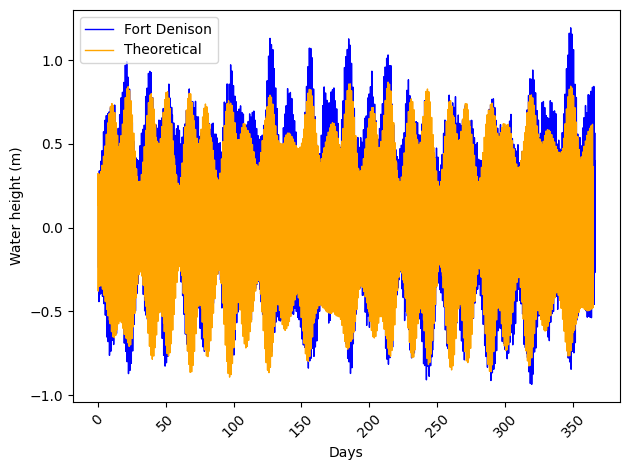

In [17]:
t = np.arange(0, 365*24*3600, 1800) # 1 year in 1800 second intervals
eta = tide.from_amplitude_phase(amp, pha, t)
fig_summary=plt.figure()
ax=fig_summary.add_subplot(111)
# note we use seconds since as t (for the theoretical plot) is also in seconds
fd = ax.plot(seconds_since/86400, FD_2008['Tide']/1000, color="blue", lw=1, label="Fort Denison")
theoretical = ax.plot(t/86400, eta, color="orange", lw=1, label="Theoretical")
ax.set_xlabel("Days")
ax.set_ylabel("Water height (m)")
ax.tick_params(axis='x', rotation=45)
# uncomment line below and rerun to see a zoom in
#ax.set_xlim([14, 44]) # only plot 30 days worth
ax.legend()
fig_summary.tight_layout()

Exercise: Create similar plots for Booby Island and Freemantle in the semi-completed code blocks below.

In [18]:
# Booby Island

In [19]:
# Freemantle

Questions to think about:


1.   None of our theoretical tidal curves are perfect. Why?
2.   How would you go about predicting tides into the future?



# Tidal modelling

Whilst the tidal gauge analysis is useful (and widely used!) it is ony one dimensional. It only give information at a single location through time. Tides are three dimensional: they also vary in space, which we can see by looking at different tide gauges. How do we fill in the space between tide gauges? Numerical modelling of the tides is the answer to that question! There are a large number of tidal models available that can simulate local, regional or global tides. Most use the Shallow Water Equations (SWE), which simulates the water surface moving up and down due to gravitational forcing and the flow of water that generates. SWE models have no vertical structure though; they simulate the ocean and seas as a single layer with a depth-averaged velocity. But because of that they are quick (relatively speaking) to run.

The big advantage of a numerical model is that you can ask hypothetical questions, such as "how will the tides change as sea-level rises?". A number of studies have done just that and found that changes in the tidal range in places will be up to 10% of the sea-level rise. This alters your flood risk at the coast by an additional 10% (either increase or decrease, but obviously a 10% increase is bad!).

We can't run a detailed model in Google Colab unfortunately, but we can have a look at the results from one and compare to tide gauges!

[In our recent paper on the future tides on the GBR](https://agupubs.onlinelibrary.wiley.com/doi/10.1029/2021JC017823), we ran tidal models for 90 simulated days (which took a few hundred cores a couple of weeks to run). We validated the model against tide gauges for the present day sea level, and then re-ran the model with 0.43 and 1.1 m of relative sea-level rise.

We're going to pull data from a station that's in our model and also grab data for that virtual tide gauge in the model and compare.

In [20]:
townsville_url = "https://uhslc.soest.hawaii.edu/data/csv/fast/hourly/h334.csv"
model_townsville_url = "https://raw.githubusercontent.com/jhill1/tidal_analysis_workshop/main/Mawson_et_al_Townsville.csv"

file_name = os.path.basename(townsville_url) # get the full path to the file
if os.path.exists(file_name):
  os.remove(file_name) # if exists, remove it directly
file_name = wget.download(townsville_url, out=".")

Townsville = read_and_process_data("h334.csv")

file_name = os.path.basename(model_townsville_url) # get the full path to the file
if os.path.exists(file_name):
  os.remove(file_name) # if exists, remove it directly
file_name = wget.download(model_townsville_url, out=".")

# Load in model data and reformat to match the tide gauge data
Model_Townsville = pd.read_csv("Mawson_et_al_Townsville.csv")
Model_Townsville['Date'] = pd.to_datetime(Model_Townsville['Time (s)'],
                                          unit='s',
                                          origin=datetime.datetime(2000,1,1,0,0,0))
Model_Townsville = Model_Townsville.rename(columns={'Height (m)': 'Tide'})
Model_Townsville = Model_Townsville.drop('Time (s)', axis=1)
Model_Townsville = Model_Townsville.set_index('Date')
# remove first 5 days (spin-up of the model) to leave 85 days of data

# Our model ran from 1st Jan 2000, so let's pull the year 2000 from the real data
Townsville_2000 = extract_single_year_remove_mean(2000, Townsville)
Townsville_2000['Tide'] /= 1000

# restrict to 85 days to match model



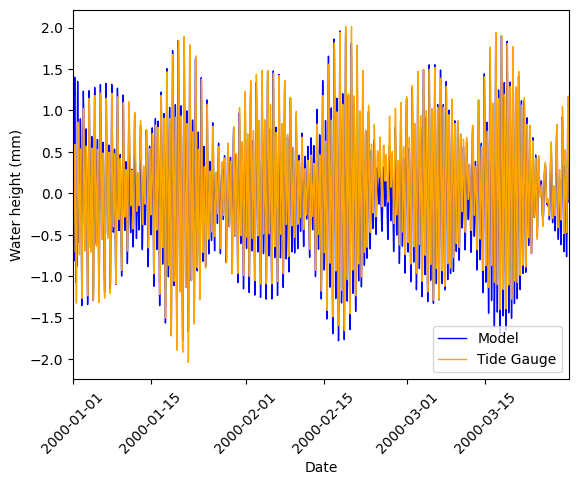

In [21]:
fig_model=plt.figure()
ax=fig_model.add_subplot(111)
fd = ax.plot(Model_Townsville['Tide'], color="blue", lw=1, label="Model")
bi = ax.plot(Townsville_2000['Tide'], color="orange", lw=1, label="Tide Gauge")
ax.set_xlabel("Date")
ax.set_ylabel("Water height (mm)")
ax.tick_params(axis='x', rotation=45)
ax.legend()
fig_june.tight_layout()

Let's analyse the model data and measured data to see how good the model is. We can see form the graph above it's not perfect, so how close is it?

The model was forced with the following consituents: M2, S2, N2, K2, K1, O1, P1, Q1, M4, MS4 and MN4


In [28]:
# check rayleigh criterion for which constiuents
constituents  = ['M2', 'S2', 'N2', 'K2', 'K1', 'O1', 'P1', 'Q1', 'M4', 'MS4', 'MN4']
print(uptide.select_constituents(constituents,85*24*60*60))


['M2', 'S2', 'N2', 'K1', 'O1', 'Q1', 'M4', 'MS4', 'MN4']


In [26]:
# Note I've adjusted the order to pull out the more important consituents first,
# removing the ones we can't resolve
constituents  = ['M2', 'S2', 'K1', 'O1', 'N2', 'Q1', 'M4', 'MS4', 'MN4']
tide = uptide.Tides(constituents)
tide.set_initial_time(datetime.datetime(2000,1,1,0,0,0))
seconds_since = (Model_Townsville.index.astype('int64').to_numpy()/1e9) - datetime.datetime(2000,1,1,0,0,0).timestamp()

m_amp,m_pha = uptide.harmonic_analysis(tide, Model_Townsville['Tide'].to_numpy(), seconds_since)
print(m_amp, np.degrees(m_pha))

[0.78089787 0.44909224 0.33318409 0.16312498 0.24638472 0.03150235
 0.05845945 0.03171804 0.01904231] [336.62556614 306.79713884  43.32995883   7.01052064 320.76549249
 350.67694277 232.06054087 233.14462226 196.02493413]


In [27]:
# The above is the model; what about the data?
seconds_since = (Townsville_2000.index.astype('int64').to_numpy()/1e9) - datetime.datetime(2000,1,1,0,0,0).timestamp()

amp,pha = uptide.harmonic_analysis(tide, Townsville_2000['Tide'].to_numpy(), seconds_since)
print(amp, np.degrees(pha))

[0.7396962  0.42765694 0.3500421  0.17249881 0.22320951 0.03066329
 0.03668082 0.00909512 0.01624012] [347.41854417 306.96784505  38.82322861  10.48947002 334.83708582
 352.42349658 267.84322584 268.49511896 244.68785059]


The Australian Hydrological Office has the following data for Townsville, which can compare to the model and a tide gauge:

Data |Q1 amp | O1 amp | P1 amp | K1 amp | N2 amp | M2 amp | S2 amp |
-----|-------|--------|--------|--------|--------|--------|--------|
AHO  | 0.0296| 0.1638 | 0.1004 | 0.3389 | 0.2374 | 0.7418 | 0.4268 |
Model| 0.0315| 0.1631 | 0.1004 | 0.3331 | 0.2463 | 0.7808 | 0.4490 |
Gauge| 0.0306| 0.1724 | 0.1004 | 0.3500 | 0.2232 | 0.7396 | 0.4276 |




Set up some exercises for students to try (e.g. repeat with OTI data). Give M2, S2 etc